In [31]:
#MODULO 1

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('est_29.csv')
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class LimpiezaDatosMicroclimas:
    """
    Versión robusta de limpieza:
    - Normaliza strings (quita unidades y símbolos)
    - Combina fecha+hora con pandas.to_datetime (múltiples formatos)
    - Convierte columnas numéricas limpiando comas/espacios
    - Interpola en base a índice datetime (NO usa estacion_sk)
    - Maneja booleanas y categorias
    """

    def __init__(self, archivo_csv):
        self.df = pd.read_csv(archivo_csv, dtype=str)  # leer todo como str para limpieza controlada
        self.df_original = self.df.copy()

        # Normalizar tokens vacíos a NaN (incluye guiones largos)
        self.df.replace(['', ' ', 'NA', 'N/A', 'null', 'Null', 'NULL', '--', '—', 'na'],
                        np.nan, inplace=True)

        # no usar estacion_sk
        if 'estacion_sk' in self.df.columns:
            self.df.drop(columns=['estacion_sk'], inplace=True)

        # Rangos recomendados)
        self.rangos_climaticos = {
            'temperatura': {'min': -10, 'max': 40},
            'humedad': {'min': 0, 'max': 100},
            'presion': {'min': 600, 'max': 620},  # mmHg
            'velocidad': {'min': 0, 'max': 100},
            'precipitacion': {'min': 0, 'max': 1000},
            'precipitacion_real': {'min': 0, 'max': 1000},
            'radiacion': {'min': 0, 'max': 2000},
            'evapotranspiracion': {'min': 0, 'max': 100},
            'evapo_real': {'min': 0, 'max': 100},
            'caudal': {'min': 0, 'max': 1e6},
            'nivel': {'min': 0, 'max': 1e6},
        }

        self.reporte = {
            'filas_originales': len(self.df),
            'duplicados_eliminados': 0,
            'valores_imputados': {},
            'outliers_detectados': {},
            'errores_datetime': 0
        }


    # Helpers de limpieza

    @staticmethod
    def _limpiar_numero_str(s):
        """
        Limpia una cadena para extraer el primer número válido.
        Reemplaza comas por puntos, elimina unidades y caracteres no numéricos
        manteniendo '.' y '-' (decimal/negativo).
        Devuelve float o np.nan.
        """
        if pd.isna(s):
            return np.nan
        s = str(s).strip()
        # Reemplazar coma decimal
        # Primero quitar espacios dentro del número
        s = s.replace('\xa0', '').replace(' ', '')
        # Reemplazar coma por punto cuando hay coma seguida de dígitos (e.g., "15,6")
        s = re.sub(r'(?<=\d),(?=\d)', '.', s)
        # Extraer el primer match de número con decimal o entero (incluye signo)
        m = re.search(r'[-+]?\d*\.\d+|[-+]?\d+', s)
        if m:
            try:
                return float(m.group(0))
            except:
                return np.nan
        return np.nan


    # 1. Crear datetime robusto

    def combinar_fecha_hora(self):
        # Algunos valores pueden venir ya en datetime en 'fecha' o 'hora'
        # Intenta concatenar y usar pd.to_datetime con dayfirst True
        df = self.df.copy()
        # Preparar strings
        df['fecha'] = df['fecha'].astype(str).str.strip().replace('nan', np.nan)
        df['hora'] = df['hora'].astype(str).str.strip().replace('nan', np.nan)

        # Concatenar cuando ambas existan
        df['__fecha_hora'] = df.apply(
            lambda r: (r['fecha'] + ' ' + r['hora']) if pd.notna(r['fecha']) and pd.notna(r['hora']) else r['fecha'] if pd.notna(r['fecha']) else np.nan,
            axis=1
        )

        # Intentar parsear con distintos parámetros
        df['datetime'] = pd.to_datetime(df['__fecha_hora'], dayfirst=True, errors='coerce', infer_datetime_format=True)

        # Si quedaron NaT, intentar parseo alternativo
        mask_bad = df['datetime'].isna() & df['__fecha_hora'].notna()
        if mask_bad.any():
            df.loc[mask_bad, 'datetime'] = pd.to_datetime(df.loc[mask_bad, '__fecha_hora'], dayfirst=False, errors='coerce', infer_datetime_format=True)

        self.df['datetime'] = df['datetime']
        self.reporte['errores_datetime'] = int(self.df['datetime'].isna().sum())

        # Para interpolaciones temporales se necesita un índice datetime
        # Mantener copia de fecha/hora originales; no las eliminamos
        # Ordenar por datetime (NaT al final)
        self.df = self.df.sort_values('datetime').reset_index(drop=True)


    # 2. Normalizar cadenas y convertir numéricos

    def convertir_numericos(self):
        # Columnas numéricas
        columnas_posibles = [
            'temperatura', 'velocidad', 'direccion', 'presion', 'humedad',
            'precipitacion', 'precipitacion_real', 'radiacion',
            'evapotranspiracion', 'evapo_real', 'caudal', 'nivel'
        ]

        for col in columnas_posibles:
            if col in self.df.columns:
                # Aplica limpieza robusta string->float
                self.df[col] = self.df[col].apply(self._limpiar_numero_str).astype(float)


    # 3. Booleanas seguras

    def convertir_booleanas(self):
        booleanas = ['puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']
        for col in booleanas:
            if col in self.df.columns:
                s = self.df[col].astype(str).str.strip().str.lower().replace('nan', np.nan)
                self.df[col] = s.map({
                    'true': True, '1': True, 'si': True, 'sí': True, 's': True,
                    'false': False, '0': False, 'no': False, 'n': False
                })
                # Si quedaron NaN, rellenar con False
                if self.df[col].isna().all():
                    # Si la columna está vacía, dejarla como False por defecto
                    self.df[col] = False
                else:
                    # imputar moda
                    try:
                        moda = self.df[col].mode().iloc[0]
                        self.df[col].fillna(moda, inplace=True)
                    except:
                        self.df[col].fillna(False, inplace=True)


    # 4. direccion_rosa como categoria

    def procesar_direccion_rosa(self):
        if 'direccion_rosa' in self.df.columns:
            self.df['direccion_rosa'] = self.df['direccion_rosa'].astype(str).str.strip().replace('nan', np.nan)
            # Normalizar a mayúsculas cortas (N, S, E, O, NE, etc.)
            self.df['direccion_rosa'] = self.df['direccion_rosa'].str.upper()
            self.df['direccion_rosa'].replace('', np.nan, inplace=True)
            # Si mucha falta, dejar NaN; imputamos moda más tarde si necesario
            try:
                # convertir a category (sin forzar)
                self.df['direccion_rosa'] = self.df['direccion_rosa'].astype('category')
            except:
                pass


    # 5. Duplicados

    def eliminar_duplicados(self):
        antes = len(self.df)
        self.df.drop_duplicates(inplace=True)
        # También intentar duplicados por datetime + otras columnas
        if 'datetime' in self.df.columns:
            self.df.drop_duplicates(subset=['datetime'], inplace=True)
        despues = len(self.df)
        self.reporte['duplicados_eliminados'] = int(antes - despues)


    # 6. Detectar outliers por rango (opcional)

    def detectar_outliers_por_rango(self):
        for col, r in self.rangos_climaticos.items():
            if col in self.df.columns:
                mask = (self.df[col] < r['min']) | (self.df[col] > r['max'])
                n_out = int(mask.sum())
                self.reporte['outliers_detectados'][col] = n_out
                # solo marcar como NaN si hay sentido hacerlo
                if n_out > 0:
                    self.df.loc[mask, col] = np.nan


    # 7. Imputación (interpolación temporal)

    def imputar(self):
        # Usar valores en 'observaciones' si extraemos info (temperatura/humedad/precipitacion)
        if 'observaciones' in self.df.columns:
            # extraer numero en observaciones para temperatura/humedad/precipitación (similar a antes)
            def extraer_obs(s, key):
                if pd.isna(s):
                    return np.nan
                s = s.lower()
                patterns = {
                    'temperatura': r'temperatura[:\s]+([0-9]+\.?[0-9]*)',
                    'humedad': r'humedad[:\s]+([0-9]+\.?[0-9]*)',
                    'precipitacion': r'precipitaci[oó]n[:\s]+([0-9]+\.?[0-9]*)'
                }
                r = patterns.get(key)
                m = re.search(r, s) if r else None
                return float(m.group(1)) if m else np.nan

            for key in ['temperatura', 'humedad', 'precipitacion']:
                if key in self.df.columns:
                    obs_col = self.df['observaciones'].apply(lambda x: extraer_obs(x, key))
                    mask = self.df[key].isna() & obs_col.notna()
                    self.df.loc[mask, key] = obs_col[mask]

        # Interpolación temporal: requerimos índice datetime
        if 'datetime' in self.df.columns:
            df_time = self.df.set_index('datetime').sort_index()
            # interpolar por tiempo sobre todo el dataset
            numeric_cols = df_time.select_dtypes(include=[np.number]).columns.tolist()
            # usar method='time' si datetime index no es monotónico (pandas lo requiere)
            try:
                df_time[numeric_cols] = df_time[numeric_cols].interpolate(method='time', limit_direction='both')
            except Exception:
                # fallback a linear
                df_time[numeric_cols] = df_time[numeric_cols].interpolate(method='linear', limit_direction='both')

            # si quedaron NaN rellenar con mediana global
            for col in numeric_cols:
                if df_time[col].isna().sum() > 0:
                    med = df_time[col].median()
                    df_time[col].fillna(med, inplace=True)
                    self.reporte['valores_imputados'][col] = int(df_time[col].isna().sum())  # aproximado

            # Restaurar
            self.df = df_time.reset_index()

        else:
            # si no hay datetime, rellenar numéricos con mediana
            numericas = [c for c in self.df.columns if self.df[c].dtype in [np.float64, np.int64]]
            for col in numericas:
                n_before = self.df[col].isna().sum()
                if n_before > 0:
                    self.df[col].fillna(self.df[col].median(), inplace=True)
                    self.reporte['valores_imputados'][col] = int(n_before)

        # Imputar direccion_rosa con moda si falta
        if 'direccion_rosa' in self.df.columns:
            try:
                moda = self.df['direccion_rosa'].mode().iloc[0]
                self.df['direccion_rosa'].fillna(moda, inplace=True)
            except:
                pass

        # Booleanas ya convertidas; asegurar no NaN
        for b in ['puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']:
            if b in self.df.columns:
                if self.df[b].isna().sum() > 0:
                    moda = self.df[b].mode().iloc[0] if not self.df[b].mode().empty else False
                    self.df[b].fillna(moda, inplace=True)


    # 8. Limpieza final y reporte

    def limpiar_final(self):
        # Asegurar que tipos están bien
        # convertir small-int columns
        # No eliminar 'fecha'/'hora' para mantener trazabilidad
        pass

    def ejecutar(self):
        # Secuencia
        self.combinar_fecha_hora()
        self.convertir_numericos()
        self.convertir_booleanas()
        self.procesar_direccion_rosa()
        self.eliminar_duplicados()
        # detectar outliers basado en rangos ajustados
        self.detectar_outliers_por_rango()
        # imputar por tiempo
        self.imputar()
        self.limpiar_final()

        # resumen final: info y conteos NaN
        reporte_basico = {
            'info': self.df.info(),
            'nulos_por_columna': self.df.isna().sum().to_dict(),
            'reporte_interno': self.reporte
        }

        return self.df, reporte_basico

limpiador = LimpiezaDatosMicroclimas('est_29.csv')
df_limpio = limpiador.ejecutar()

df_limpio[0].to_csv('est_29_limpio.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903391 entries, 0 to 903390
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            903391 non-null  datetime64[ns]
 1   fecha               903391 non-null  object        
 2   hora                903391 non-null  object        
 3   temperatura         903391 non-null  float64       
 4   velocidad           903391 non-null  float64       
 5   direccion           903391 non-null  float64       
 6   direccion_rosa      903391 non-null  category      
 7   caudal              903391 non-null  float64       
 8   presion             903391 non-null  float64       
 9   humedad             903391 non-null  float64       
 10  precipitacion       903391 non-null  float64       
 11  precipitacion_real  903391 non-null  float64       
 12  radiacion           903391 non-null  float64       
 13  evapotranspiracion  903391 no

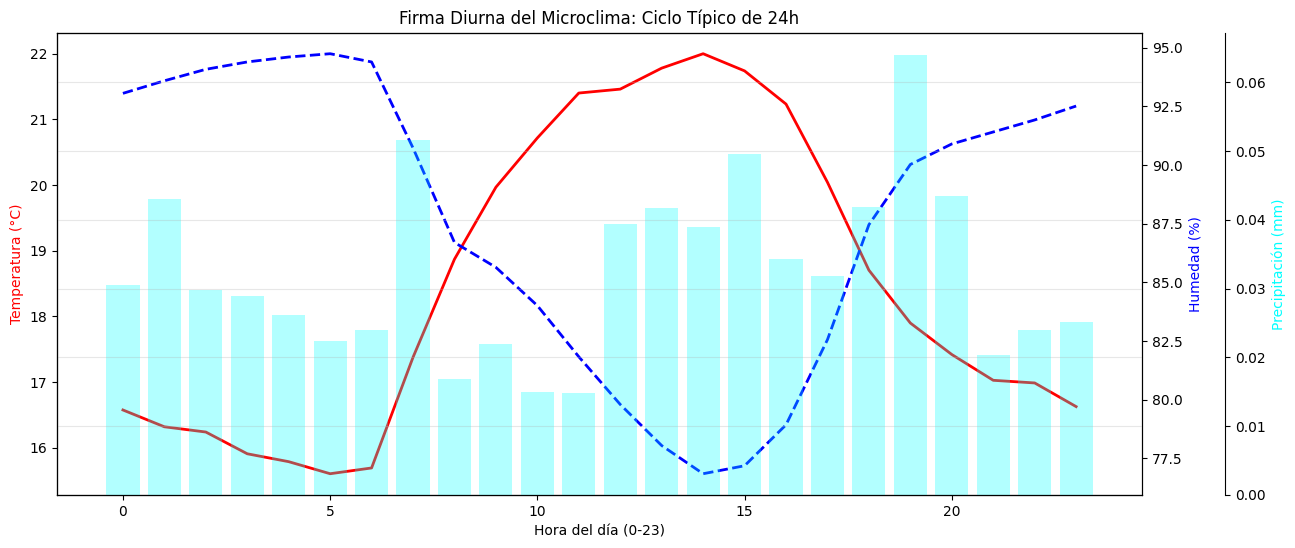

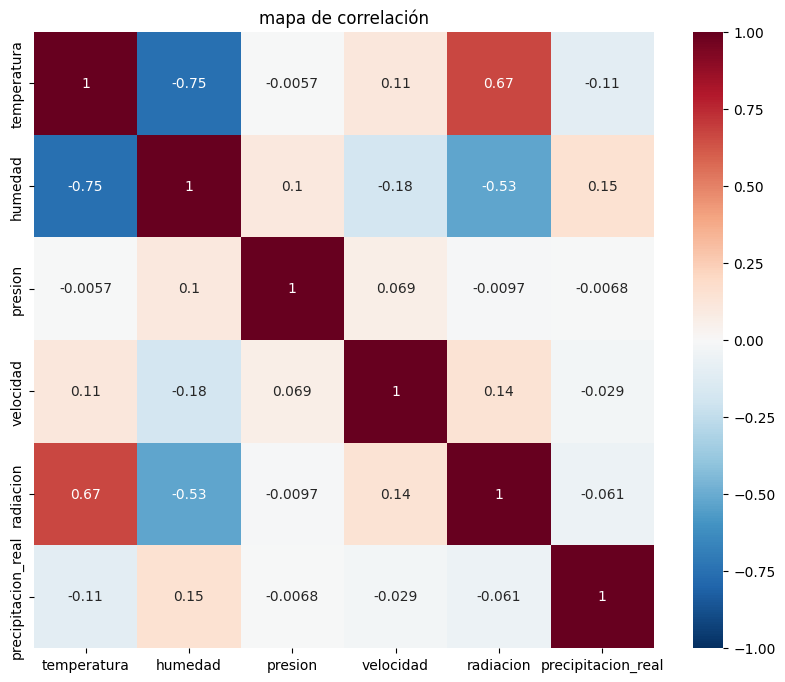

Usando columna numérica original 'direccion'


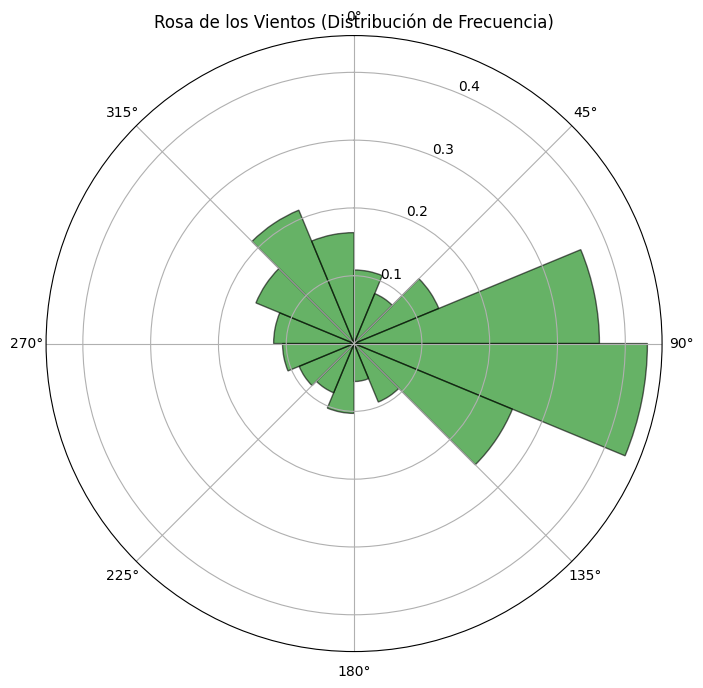

In [33]:

# 1. PREPARACIÓN DEL DATAFRAME

df_eda = df_limpio[0].copy() # Corrected: Access the DataFrame from the tuple

# Aseguramos que el índice sea datetime para las series de tiempo
if 'datetime' in df_eda.columns:
    df_eda = df_eda.set_index('datetime').sort_index()

# Filtramos solo columnas físicas útiles para el clima
cols_fisicas = ['temperatura', 'humedad', 'presion', 'velocidad',
                'radiacion', 'precipitacion_real']

# Filtramos solo las que realmente existan en el df
cols_plot = [c for c in cols_fisicas if c in df_eda.columns]
df_fisico = df_eda[cols_plot]


# 2. IDENTIFICACIÓN DE LA "FIRMA DEL MICROCLIMA" (Ciclo Diurno)

# Esto responde: ¿Cómo se comporta ESTA zona específica durante el día?
df_fisico['hora'] = df_fisico.index.hour
promedios_hora = df_fisico.groupby('hora').mean()
# Para lluvia usamos suma (o promedio, depende si se requiere intensidad o probabilidad)
lluvia_hora = df_fisico.groupby('hora')['precipitacion_real'].mean()

plt.figure(figsize=(14, 6))

# Eje izquierdo: Temperatura y Humedad
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(promedios_hora.index, promedios_hora['temperatura'], 'r-', lw=2, label='Temperatura')
ax2.plot(promedios_hora.index, promedios_hora['humedad'], 'b--', lw=2, label='Humedad')

# Añadimos barras de lluvia de fondo
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60)) # Mover eje para que no se solape
ax3.bar(lluvia_hora.index, lluvia_hora.values, color='cyan', alpha=0.3, label='Precipitación')

ax1.set_ylabel('Temperatura (°C)', color='r')
ax2.set_ylabel('Humedad (%)', color='b')
ax3.set_ylabel('Precipitación (mm)', color='cyan')
ax1.set_xlabel('Hora del día (0-23)')
plt.title(f'Firma Diurna del Microclima: Ciclo Típico de 24h')
plt.grid(True, alpha=0.3)
plt.show()


# 3. MATRIZ DE CORRELACIÓN FÍSICA

plt.figure(figsize=(10, 8))
# Usamos Spearman porque las relaciones en clima no siempre son lineales
corr = df_fisico.drop(columns=['hora']).corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('mapa de correlación')
plt.show()


# 4. ANÁLISIS DE VIENTO (CORREGIDO: Usando direccion_rosa)


# 1. Definimos un diccionario para convertir Letras a Grados
mapa_rosa = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# 2. Verificamos cuál columna usar
datos_viento = None

# Opción A: Si la numérica sirve (y no es todo NaN)
if 'direccion' in df_eda.columns and df_eda['direccion'].notna().sum() > 10:
    datos_viento = df_eda['direccion'].dropna()
    print("Usando columna numérica original 'direccion'")

# 3. Graficamos solo si tenemos datos
if datos_viento is not None and not datos_viento.empty:
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Convertimos grados a radianes (Matplotlib polar necesita radianes)
    theta = np.deg2rad(datos_viento.values)

    # Histograma
    # bins=16 para que coincida con las 16 direcciones del viento (N, NNE, etc)
    bars = ax.hist(theta, bins=16, density=True,
                   color='green', alpha=0.6, edgecolor='k')

    ax.set_theta_zero_location("N") # Norte arriba
    ax.set_theta_direction(-1)      # Sentido horario
    plt.title("Rosa de los Vientos (Distribución de Frecuencia)")
    plt.show()
else:
    print("ERROR: No hay datos válidos de dirección de viento para graficar.")


In [34]:
#MODULO 2

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. CARGA DE DATOS
archivo = 'est_29_limpio.csv'
df = pd.read_csv(archivo, parse_dates=['datetime'], index_col='datetime')

# 2. SELECCIÓN DE VARIABLES PARA EL CLUSTERING
# No metemos la lluvia como target, sino como característica para ver cómo se agrupa.
features = ['temperatura', 'humedad', 'presion', 'velocidad', 'radiacion', 'precipitacion_real']

# Filtramos solo las columnas que existen y eliminamos filas vacías
cols_validas = [c for c in features if c in df.columns]
df_cluster = df[cols_validas].dropna()
print(df_cluster)

# 3. ESCALADO DE DATOS (StandardScaler)
# Transforma los datos para que media=0 y desviación=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Datos escalados y listos para agrupar.")
print(f"Dimensiones: {X_scaled.shape}")

                     temperatura  humedad  presion  velocidad  radiacion  \
datetime                                                                   
2012-03-28 00:57:54        14.89     99.0   601.27   0.000000        0.0   
2012-03-28 01:08:17        14.89     98.0   601.27   0.000000        0.0   
2012-03-28 01:13:15        14.89     98.0   601.27   0.000000        0.0   
2012-03-28 01:47:56        14.67     99.0   601.27   0.000000        0.0   
2012-03-28 01:53:46        14.61    100.0   601.27   0.114945        0.0   
...                          ...      ...      ...        ...        ...   
2021-02-04 14:45:29        22.33     65.0   600.02   0.000000      643.0   
2021-02-04 14:50:26        22.67     63.0   600.02   0.890000      629.0   
2021-02-04 14:55:27        23.11     59.0   600.02   1.340000      596.0   
2021-02-04 15:00:27        23.39     61.0   600.02   0.450000      570.0   
2021-02-04 15:05:39        23.50     61.0   600.02   0.450000      617.0   

           

In [36]:
# Calcular la inercia (suma de distancias al cuadrado) para diferentes K
inercias = []
rango_k = range(1, 10)

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)


In [37]:

K_OPTIMO = 2

# 1. Aplicar K-Means Final
kmeans = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Guardamos el cluster en el dataframe original para analizarlo
df_cluster['Cluster'] = clusters


In [38]:
# Agrupamos por cluster y sacamos el promedio de las variables originales
perfil_microclimas = df_cluster.groupby('Cluster').mean()

# Agregamos la cantidad de horas que pertenece a cada clima
perfil_microclimas['Horas_Detectadas'] = df_cluster['Cluster'].value_counts()

print("--- CARACTERIZACIÓN DE LOS MICROCLIMAS DETECTADOS ---")
print(perfil_microclimas)

--- CARACTERIZACIÓN DE LOS MICROCLIMAS DETECTADOS ---
         temperatura    humedad     presion  velocidad   radiacion  \
Cluster                                                              
0          17.583865  92.079605  600.388232   0.526960   43.298337   
1          21.151191  74.583055  600.506848   1.008663  431.666370   

         precipitacion_real  Horas_Detectadas  
Cluster                                        
0                  0.028931            678350  
1                  0.043262            225041  


In [46]:
df_cluster.to_csv('df_cluster_29.csv', index=True)

In [39]:
#MODULO 3

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              RandomForestClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier


In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
ARCHIVO_DATOS = 'df_cluster_29.csv'
TEST_SIZE = 0.2
UMBRAL_LLUVIA = 0.2  # mm
RANDOM_STATE = 42

In [50]:
df = pd.read_csv('df_cluster_29.csv' ,parse_dates=['datetime'], index_col='datetime')

In [51]:
def crear_features_completas(df):
    df_feat = df.copy()

    # Temporales
    df_feat['hora'] = df_feat.index.hour
    df_feat['dia_semana'] = df_feat.index.dayofweek
    df_feat['mes'] = df_feat.index.month
    df_feat['dia_año'] = df_feat.index.dayofyear

    # Cíclicas
    df_feat['hora_sin'] = np.sin(2 * np.pi * df_feat['hora'] / 24)
    df_feat['hora_cos'] = np.cos(2 * np.pi * df_feat['hora'] / 24)
    df_feat['mes_sin'] = np.sin(2 * np.pi * df_feat['mes'] / 12)
    df_feat['mes_cos'] = np.cos(2 * np.pi * df_feat['mes'] / 12)

    # Variables meteorológicas
    vars_meteo = ['temperatura', 'humedad', 'presion', 'velocidad', 'radiacion']

    # Lags
    for var in vars_meteo + ['precipitacion_real']:
        if var in df_feat.columns:
            for lag in [1, 3, 6, 12, 24]:
                df_feat[f'{var}_lag{lag}'] = df_feat[var].shift(lag)

    # Rolling
    for var in vars_meteo:
        if var in df_feat.columns:
            for w in [3, 6, 12]:
                df_feat[f'{var}_roll{w}'] = df_feat[var].rolling(w).mean()

    # Diferencias
    for var in vars_meteo:
        if var in df_feat.columns:
            df_feat[f'{var}_diff'] = df_feat[var].diff()

    return df_feat

In [52]:
df_features = crear_features_completas(df)
df_features = df_features.dropna()

In [53]:
# Crear targets
df_features['target_precipitacion'] = df_features['precipitacion_real'].shift(-1)
df_features['target_lluvia_binaria'] = (df_features['target_precipitacion'] > UMBRAL_LLUVIA).astype(int)
df_features = df_features.dropna(subset=['target_precipitacion'])

In [54]:
# Seleccionar features
excluir = ['precipitacion_real', 'target_precipitacion', 'target_lluvia_binaria',
           'fecha', 'hora', 'direccion_rosa', 'observaciones',
           'puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']

feature_cols = [col for col in df_features.columns
                if col not in excluir and df_features[col].dtype in ['float64', 'int64']]

print(f"Features seleccionadas: {len(feature_cols)}")

# División temporal
n = len(df_features)
split_idx = int(n * (1 - TEST_SIZE))

train_df = df_features.iloc[:split_idx]
test_df = df_features.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train_reg = train_df['target_precipitacion']
y_train_clf = train_df['target_lluvia_binaria']

X_test = test_df[feature_cols]
y_test_reg = test_df['target_precipitacion']
y_test_clf = test_df['target_lluvia_binaria']

print(f" Train: {len(train_df)} | Test: {len(test_df)}")
# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

Features seleccionadas: 60
 Train: 722692 | Test: 180674


In [55]:
modelos_reg = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15,
                                          random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5,
                           learning_rate=0.1, random_state=RANDOM_STATE)
}

resultados_reg = {}

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for nombre, modelo in modelos_reg.items():
    modelo.fit(X_train_scaled, y_train_reg)
    y_pred = modelo.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    mae = mean_absolute_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)

    resultados_reg[nombre] = {
        'modelo': modelo,
        'predicciones': y_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"  {nombre:20s} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

  Linear               | RMSE: 0.1439 | MAE: 0.0641 | R²: -0.1912
  Ridge                | RMSE: 0.1439 | MAE: 0.0641 | R²: -0.1911
  Decision Tree        | RMSE: 0.1241 | MAE: 0.0175 | R²: 0.1145
  Random Forest        | RMSE: 0.3580 | MAE: 0.0196 | R²: -6.3700
  XGBoost              | RMSE: 0.2391 | MAE: 0.0218 | R²: -2.2881


In [58]:
# Mejor modelo
mejor_reg = min(resultados_reg.keys(), key=lambda x: resultados_reg[x]['rmse'])
print(f"\n✓ Mejor modelo de regresión: {mejor_reg}")


✓ Mejor modelo de regresión: Decision Tree


In [59]:
modelos_clf = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15,
                                           random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5,
                            learning_rate=0.1, random_state=RANDOM_STATE,
                            eval_metric='logloss')
}


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

resultados_clf = {}
for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train_scaled, y_train_clf)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred, zero_division=0)
    rec = recall_score(y_test_clf, y_pred, zero_division=0)
    f1 = f1_score(y_test_clf, y_pred, zero_division=0)
    auc = roc_auc_score(y_test_clf, y_proba) if len(np.unique(y_test_clf)) > 1 else 0

    resultados_clf[nombre] = {
        'modelo': modelo,
        'predicciones': y_pred,
        'probabilidades': y_proba,
        'acc': acc,
        'f1': f1,
        'auc': auc
    }

    print(f"  {nombre:20s} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

mejor_clf = max(resultados_clf.keys(), key=lambda x: resultados_clf[x]['f1'])
print(f"\n✓ Mejor modelo de clasificación: {mejor_clf}")

  Logistic             | Acc: 0.9893 | F1: 0.0623 | AUC: 0.9203
  Decision Tree        | Acc: 0.9902 | F1: 0.4688 | AUC: 0.9213
  Random Forest        | Acc: 0.9907 | F1: 0.3914 | AUC: 0.9642
  XGBoost              | Acc: 0.9905 | F1: 0.4574 | AUC: 0.9680

✓ Mejor modelo de clasificación: Decision Tree


In [61]:
if 'Cluster' in df_features.columns:
    # Predecir en todo el dataset
    X_all_scaled = scaler.transform(df_features[feature_cols])

    modelo_reg_final = resultados_reg[mejor_reg]['modelo']
    modelo_clf_final = resultados_clf[mejor_clf]['modelo']

    pred_cantidad = modelo_reg_final.predict(X_all_scaled)
    pred_lluvia = modelo_clf_final.predict(X_all_scaled)
    pred_proba = modelo_clf_final.predict_proba(X_all_scaled)[:, 1]

    df_features['pred_cantidad_mm'] = pred_cantidad
    df_features['pred_va_llover'] = pred_lluvia
    df_features['prob_lluvia'] = pred_proba

In [62]:
if 'Cluster' in df_features.columns:
    for cluster in sorted(df_features['Cluster'].unique()):
        mask = df_features['Cluster'] == cluster
        datos = df_features[mask]

        prec_real_mean = datos['precipitacion_real'].mean()
        prec_pred_mean = datos['pred_cantidad_mm'].mean()
        freq_real = (datos['precipitacion_real'] > UMBRAL_LLUVIA).mean() * 100
        prob_mean = datos['prob_lluvia'].mean()

        print(f"\nMICROCLIMA {cluster} ({len(datos)} obs):")
        print(f"  Precip. real:    {prec_real_mean:.3f} mm")
        print(f"  Precip. predicha: {prec_pred_mean:.3f} mm")
        print(f"  Freq. lluvia:     {freq_real:.1f}%")
        print(f"  Prob. media:      {prob_mean:.2%}")
else:
    print("\n⚠ No se encontró columna 'Cluster'. Ejecuta Módulo 2 primero para realizar el análisis por microclima.")


MICROCLIMA 0 (678326 obs):
  Precip. real:    0.029 mm
  Precip. predicha: 0.031 mm
  Freq. lluvia:     2.8%
  Prob. media:      2.76%

MICROCLIMA 1 (225040 obs):
  Precip. real:    0.043 mm
  Precip. predicha: 0.037 mm
  Freq. lluvia:     0.4%
  Prob. media:      0.61%


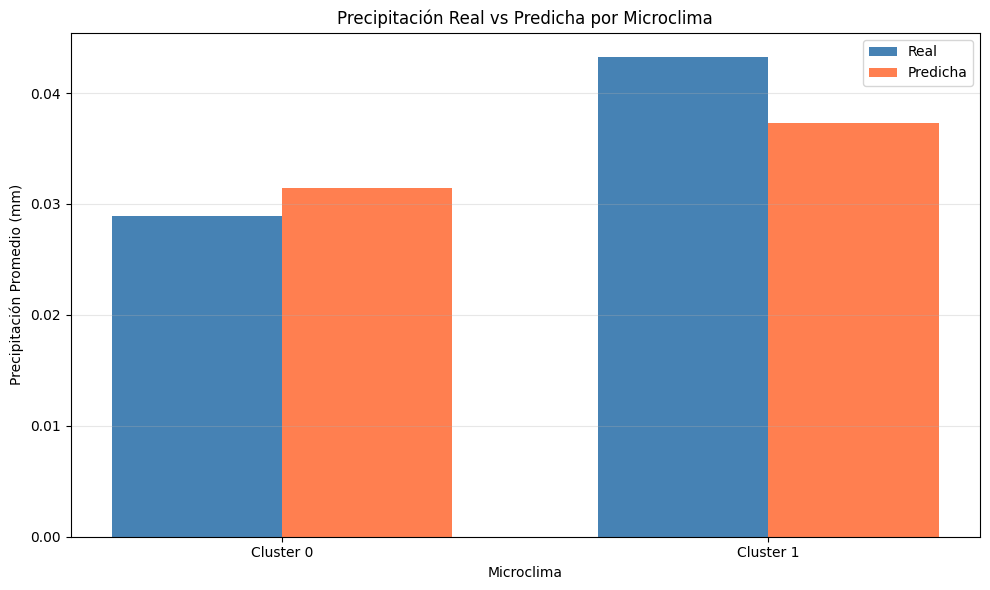


✓ Predicciones por microclima completadas


In [63]:
if 'Cluster' in df_features.columns:
    clusters = sorted(df_features['Cluster'].unique())
    data_plot = []
    for c in clusters:
        mask = df_features['Cluster'] == c
        real = df_features.loc[mask, 'precipitacion_real'].mean()
        pred = df_features.loc[mask, 'pred_cantidad_mm'].mean()
        data_plot.append({'Cluster': c, 'Real': real, 'Predicha': pred})

    df_plot = pd.DataFrame(data_plot)

    plt.figure(figsize=(10, 6))
    x = np.arange(len(df_plot))
    width = 0.35

    plt.bar(x - width/2, df_plot['Real'], width, label='Real', color='steelblue')
    plt.bar(x + width/2, df_plot['Predicha'], width, label='Predicha', color='coral')
    plt.xlabel('Microclima')
    plt.ylabel('Precipitación Promedio (mm)')
    plt.title('Precipitación Real vs Predicha por Microclima')
    plt.xticks(x, [f'Cluster {c}' for c in df_plot['Cluster']])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✓ Predicciones por microclima completadas")
else:
    print("\n⚠ No se encontró columna 'Cluster'. Ejecuta Módulo 2 primero.")